In [1]:
!pip install flax optax

In [2]:
import optax
import matplotlib.pyplot as plt
from optax import OptState, GradientTransformation, Params
from tqdm.notebook import tqdm
from jax import numpy as jnp, value_and_grad, jit, random
from flax.linen import Module, Dense, sigmoid
from jax.typing import ArrayLike
from typing import Tuple, Callable, Dict, List

plt.style.use("ggplot")

In [3]:
key = random.PRNGKey(42)
key_x, key_y, key_model = random.split(key, 3)

In [4]:
keys = {
    "x": key_x,
    "y": key_y,
    "model": key_model
}

In [5]:
Data = Dict[str, ArrayLike]
def get_data(keys: Dict[str, random.PRNGKey], n_samples: int) -> Data:
    data = {
        "x": random.uniform(
            keys["x"], shape=(n_samples, 1), minval=-1, maxval=1
            )
    }
    data["y"] = (
        data["x"] ** 2 +
        random.normal(keys["y"], shape=(n_samples, 1)) * 0.1
    )
    data["y"] = (
        (data["y"] - data["y"].min()) /
        (data["y"].max() - data["y"].min())
        )
    return data

In [6]:
def split_data(data: Data, test_size: float) -> Tuple[Data, Data]:
    n_train = int((1 - test_size) * data["x"].size)
    train_data = {
        "x": data["x"][:n_train],
        "y": data["y"][:n_train]
    }
    test_data = {
        "x": data["x"][n_train:],
        "y": data["y"][n_train:]
    }
    return train_data, test_data

In [7]:
data = get_data(keys, 200)
train_data, test_data = split_data(data, .5)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

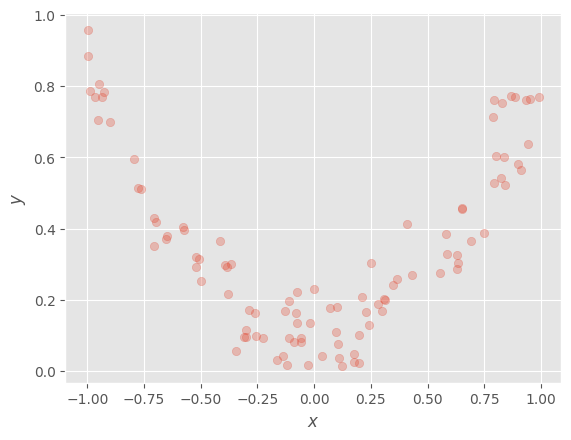

In [8]:
fig, ax = plt.subplots()
ax.scatter(train_data["x"], train_data["y"], alpha=0.3)
ax.set(xlabel="$x$", ylabel="$y$")

In [9]:
class Regressor(Module):

    def setup(self):
        self.layer1 = Dense(features=512)
        self.layer2 = Dense(features=256)
        self.layer3 = Dense(features=128)
        self.layer4 = Dense(features=64)
        self.layer5 = Dense(features=32)
        self.layer6 = Dense(features=16)
        self.out_layer = Dense(features=1)

    def __call__(self, x: ArrayLike) -> ArrayLike:
        h = sigmoid(self.layer1(x))
        h = sigmoid(self.layer2(h))
        h = sigmoid(self.layer3(h))
        h = sigmoid(self.layer4(h))
        h = sigmoid(self.layer5(h))
        h = sigmoid(self.layer6(h))
        return self.out_layer(h)

In [10]:
model = Regressor()

In [11]:
print(model.tabulate(keys["model"], train_data["x"]))


                               Regressor Summary                                
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module    ┃ inputs          ┃ outputs          ┃ params          ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│           │ Regressor │ float32[100,1]  │ float32[100,1]   │                 │
├───────────┼───────────┼─────────────────┼──────────────────┼─────────────────┤
│ layer1    │ Dense     │ float32[100,1]  │ float32[100,512] │ bias:           │
│           │           │                 │                  │ float32[512]    │
│           │           │                 │                  │ kernel:         │
│           │           │                 │                  │ float32[1,512]  │
│           │           │                 │                  │                 │
│           │           │                 │                  │ 1,024 (4.1 KB)  │
├───────────┼───────────┼──

In [12]:
def get_loss(data: Data, model: Module) -> Callable[[Params], ArrayLike]:
    def loss(params: Params) -> ArrayLike:
        y_pred = model.apply(params, data["x"])
        loss_val = optax.sigmoid_binary_cross_entropy(y_pred, data["y"])
        return loss_val.mean()
    return jit(loss)

In [13]:
params = model.init(keys["model"], data["x"])

In [14]:
train_loss_fn = get_loss(train_data, model)
test_loss_fn = get_loss(test_data, model)
grad_fn = value_and_grad(train_loss_fn)

In [15]:
train_loss_fn(params)

Array(0.6495259, dtype=float32)

In [16]:
grad_fn(params)

(Array(0.6495259, dtype=float32),
 {'params': {'layer1': {'bias': Array([-3.91407923e-07,  8.12181185e-08,  1.17739305e-07,  4.96702341e-07,
            3.48129419e-08,  1.64882067e-07, -2.53777479e-08,  9.09075766e-08,
           -1.02697300e-07, -1.01933209e-08,  3.51462006e-07,  3.18100803e-07,
            1.69903558e-09,  2.79431411e-08, -9.04153978e-07, -2.21382095e-07,
           -1.88096827e-08, -3.28195142e-08,  2.25126897e-07,  3.16798889e-08,
           -8.18734520e-07, -2.62136240e-07,  1.82923259e-08,  1.28790418e-07,
           -1.47604396e-07,  3.83132431e-07,  6.10061363e-07,  3.66457833e-08,
            2.24416468e-07, -4.42226280e-07,  9.87864951e-07,  2.58591740e-07,
            3.20635394e-07, -5.35738309e-07,  1.24765521e-07,  4.78234092e-08,
            4.20287648e-07, -5.64911204e-07,  2.86312172e-07, -1.98643193e-07,
           -2.75181606e-07,  2.51331045e-09,  8.53405254e-07,  2.36853708e-07,
            4.49596200e-07, -4.39973348e-07, -1.51156144e-07, -4.3018

In [17]:
opt = optax.adam(learning_rate=1e-5)
opt_state = opt.init(params)

In [18]:
@jit
def train_step(
    params: Params, opt_state: OptState
    ) -> Tuple[ArrayLike, Params, OptState]:
    value, grad = grad_fn(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state

In [19]:
train_step(params, opt_state)

(Array(0.6495259, dtype=float32),
 {'params': {'layer1': {'bias': Array([ 9.7510965e-06, -8.9039095e-06, -9.2173505e-06, -9.8028677e-06,
           -7.7686400e-06, -9.4283914e-06,  7.1734830e-06, -9.0091808e-06,
            9.1128586e-06,  5.0479257e-06, -9.7235643e-06, -9.6954336e-06,
           -1.4522914e-06, -7.3646024e-06,  9.8908358e-06,  9.5680261e-06,
            6.5290424e-06,  7.6647511e-06, -9.5749101e-06, -7.6008937e-06,
            9.8795581e-06,  9.6327522e-06, -6.4655692e-06, -9.2796881e-06,
            9.3657036e-06, -9.7458524e-06, -9.8389501e-06, -7.8563253e-06,
           -9.5736214e-06,  9.7790926e-06, -9.9000126e-06, -9.6279018e-06,
           -9.6977692e-06,  9.8169839e-06, -9.2581686e-06, -8.2707547e-06,
           -9.7678176e-06,  9.8262817e-06, -9.6627336e-06,  9.5209234e-06,
            9.6495605e-06, -2.0085183e-06, -9.8844057e-06, -9.5951145e-06,
           -9.7826387e-06,  9.7779848e-06,  9.3796871e-06,  8.1140188e-06,
            9.8303854e-06,  9.6798594e

In [20]:
LossLog = List[ArrayLike]
def fit(
    params: Params, opt: GradientTransformation, opt_state: OptState,
    n_iters: int
    ) -> Tuple[Params, LossLog, LossLog]:
    pbar = tqdm(range(n_iters))
    train_log = []
    test_log = []
    for _ in pbar:
        train_loss, params, opt_state = train_step(params, opt_state)
        test_loss = test_loss_fn(params)
        pbar.set_description(f"Train loss: {train_loss:.4f} - Test loss: {test_loss:.4f}")
        train_log.append(train_loss)
        test_log.append(test_loss)
    return params, train_log, test_log


In [31]:
params = model.init(keys["model"], data["x"])
opt = optax.adam(learning_rate=1e-6)
opt_state = opt.init(params)

In [32]:
params, train_log, test_log = fit(params, opt, opt_state, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

[Text(0.5, 0, 'Iter'), Text(0, 0.5, 'Loss')]

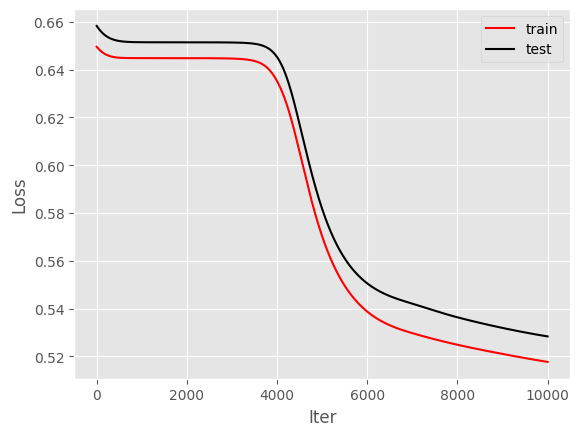

In [33]:
fig, ax = plt.subplots()
ax.plot(train_log, label="train", color="r")
ax.plot(test_log, label="test", color="k")
ax.legend()
ax.set(xlabel="Iter", ylabel="Loss")

In [34]:
x_range = jnp.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = sigmoid(model.apply(params, x_range))

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

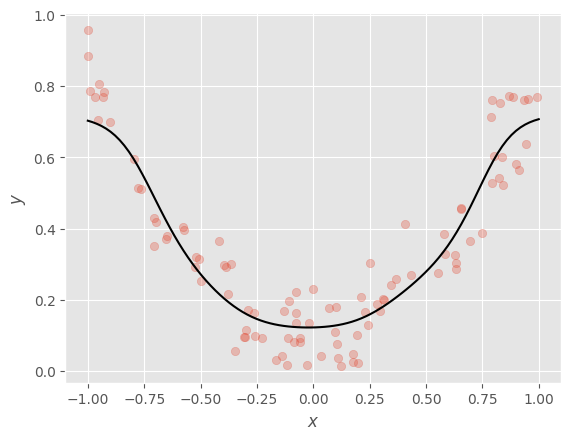

In [35]:
fig, ax = plt.subplots()
ax.scatter(train_data["x"], train_data["y"], alpha=0.3)
ax.plot(x_range, y_pred, color="k")
ax.set(xlabel="$x$", ylabel="$y$")